### Лабораторная работа 3. Ансамбли, отбор признаков

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков Jupyter (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете так же должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам —  проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.


### Оценивание и штрафы

* Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи)
* Максимально допустимая оценка за работу — 20 баллов
* Сдавать задание после указанного срока сдачи нельзя
* «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса)
* Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник)
* Не оцениваются задания с удалёнными формулировками
* Не оценивается лабораторная работа целиком, если она была выложена в открытый источник

## Введение

Обратившись к Питеру Флаху, перечислим еще раз три ингридиента машинного обучения: задачи, модели и признаки.

Наш курс вводный, и темы извлечения признаков затрагивает очень неглубоко (на ум приходят модели мешка слов или использование дерева решений, как генератора категориального признака "номер листа"). 

На вводной лекции Саша Крайнов рассказывал вам о том, что в задачах машинного зрения применяется подход, когда одна нейронная сеть обучает и "извлекатель признаков" (на жаргоне -- тушка) и классификатор поверх данного слоя признаков (на жаргоне -- голову). 
В данной лабораторной работе (и сопряженным с ней конкурсе) мы возьмём предобученную нейронную сеть, входящую в набор моделей torchvision.models, и оставим от нее только "тушку". Таким образом у нас будет генератор признаков.

Мы сгенерировали для вас dataset с извлечёнными из картинок признаками.

Как вы понимаете, нет никаких гарантий, что данный набор признаков будет полезен для нашей задачи.

А значит, вы сможете:
  * применить методы отбора признаков 
  * обучить на лучших подмножествах модели, которые вы еще не испытвали в лабораторных
    * модели на основе растояний
    * деревья решений
    * ансамбли над деревьями решений.
  * отобрать лучшие модели
  
И получить таким образом хорошее baseline решение для конкурса.

## Задача и Dataset

Данные о задаче доступны в соревновании https://www.kaggle.com/t/c5b18ffd89ec43aa95477548b54f0e7e

Метрика -- AUC ROC

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from time import time
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
import optuna
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import shap
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import tree
from IPython.display import Image
import pydotplus
import pandas as pd
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.inspection import permutation_importance
%matplotlib inline

In [3]:
full_train = pd.read_csv("train.csv")
full_test = pd.read_csv("test.csv")
example = pd.read_csv("sample_submission.csv")

Проверка на np.nan in pd.DataFrame

In [10]:
print(full_train.isnull().values.any())
print(full_test.isnull().values.any())

False
False


### кросс-валидация

In [5]:
X_my_train, X_my_test, y_my_train, y_my_test = train_test_split(full_train.drop(columns = 'label'),
                                                                full_train['label'],
                                                                test_size=0.2, random_state=42)
print(X_my_train.shape) # full -> X_my_train, X_my_test, y_my_train, y_my_test

(3328, 512)


In [6]:
X_my_cv_train, X_my_cv_test, y_my_cv_train, y_my_cv_test = train_test_split(X_my_train,
                                                                y_my_train,
                                                                test_size=0.2, random_state=42)
print(X_my_cv_train.shape) # my_train -> X_my_cv_train, X_my_cv_test, y_my_cv_train, y_my_cv_test

(2662, 512)


### simple log reg

In [13]:
clf = LogisticRegression(solver="liblinear", random_state=0).fit(X_my_train, y_my_train)
roc_auc_score(y_my_test, clf.predict_proba(X_my_test)[:, 1])

0.7818459191456902

**Задание 1** (2.5 балла)
Оцените признаки до моделирования тяжелыми моделями.
  * Оцените связь между целевой меткой и значением признкак при помощи статистических тестов, воспользщовавшись разделом [Univariate feature selection из skalern](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)
  * Отранжируйте признаки при помощи линейного классификатора с l1-регуляризацией (например, воспользовавшись [l1-based-feature-selection из sklearn](https://scikit-learn.org/stable/modules/feature_selection.html#l1-based-feature-selection))


In [13]:
# full_train.drop(columns = 'label'), full_train['label']
print(X_my_train.shape) # full -> X_my_train, X_my_test, y_my_train, y_my_test
print(X_my_cv_train.shape) # my_train -> X_my_cv_train, X_my_cv_test, y_my_cv_train, y_my_cv_test
X_my_train, X_my_test, y_my_train, y_my_test = train_test_split(full_train.drop(columns = 'label'),
                                                                full_train['label'],
                                                                test_size=0.2, random_state=42)

(3328, 512)
(2662, 512)


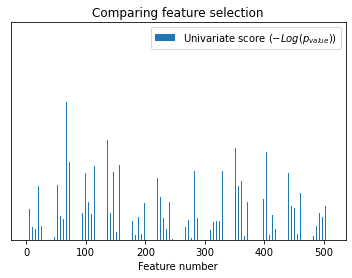

In [86]:
selector = SelectKBest(chi2, k=4)
selector.fit(X_my_train, y_my_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
X_indices = np.arange(full_train.drop(columns = 'label').shape[-1])
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)')

plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

In [14]:
# чем меньше C, тем меньше параметров отберём
lsvc = LogisticRegression(C=1, solver="liblinear", penalty="l1").fit(
    full_train.drop(columns = 'label'), full_train['label'])
model = SelectFromModel(lsvc, prefit=True)
X_full_train_l1_selection_log_reg = model.transform(full_train.drop(columns = 'label'))
X_full_train_l1_selection_log_reg.shape

(4161, 301)

In [15]:
full_train.drop(columns = 'label').columns[model.get_support()]

Index(['A_000', 'A_001', 'A_003', 'A_005', 'A_006', 'A_008', 'A_009', 'A_011',
       'A_013', 'A_014',
       ...
       'A_498', 'A_500', 'A_501', 'A_502', 'A_504', 'A_505', 'A_507', 'A_508',
       'A_509', 'A_511'],
      dtype='object', length=301)

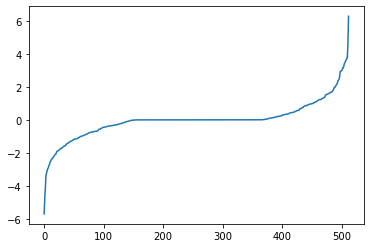

In [16]:
plt.plot(range(512), np.sort(lsvc.coef_).reshape(512))

In [104]:
lsvc = LogisticRegression(C=1, solver="liblinear", penalty="l1").fit(X_my_train, y_my_train)
model = SelectFromModel(lsvc, prefit=True)
X_my_train_l1_selection_log_reg = model.transform(X_my_train)
X_my_train_l1_selection_log_reg.shape

clf = LogisticRegression(solver="liblinear", random_state=0).fit(X_my_train_l1_selection_log_reg, y_my_train)
roc_auc_score(y_my_test, clf.predict_proba(model.transform(X_my_test))[:, 1])

0.7772461456671984

In [42]:
features_cur_task = full_train.drop(columns = 'label').columns[model.get_support()]
zero_feaures_cur_task = full_train.drop(columns = 'label').columns[np.logical_not(model.get_support())]
coef = lsvc.coef_[lsvc.coef_ != 0]
features_coef_cur_task = np.hstack((np.array(features_cur_task).reshape(len(coef), 1), coef.reshape(len(coef), 1)))
sorted_features_coef_cur_task = features_coef_cur_task[np.argsort(features_coef_cur_task[:, 1])]

In [48]:
print("Best 10 features by l1: " + str(sorted_features_coef_cur_task[:10][:, 0]))
print("Useless features by l1: " + str(zero_feaures_cur_task))

Best 10 features by l1: ['A_150' 'A_068' 'A_295' 'A_203' 'A_137' 'A_413' 'A_395' 'A_505' 'A_090'
 'A_071']
Useless features by l1: Index(['A_002', 'A_004', 'A_007', 'A_010', 'A_012', 'A_018', 'A_020', 'A_023',
       'A_026', 'A_027',
       ...
       'A_483', 'A_485', 'A_489', 'A_495', 'A_496', 'A_497', 'A_499', 'A_503',
       'A_506', 'A_510'],
      dtype='object', length=211)


1я часть показала что есть около 80 сильных признаков. 2я - l1 регуляризация занулила 211 фич 

**Задание 2** (1 балл)
    Попробуйте снизить размерность базовго набора признаков при помощи PCA.
    Визуализируйте первые 2 главные компоненты, раскрасив примеры меткой класса

In [53]:
# full_train.drop(columns = 'label'), full_train['label']
print(X_my_train.shape) # full -> X_my_train, X_my_test, y_my_train, y_my_test
print(X_my_cv_train.shape) # my_train -> X_my_cv_train, X_my_cv_test, y_my_cv_train, y_my_cv_test
X_my_train, X_my_test, y_my_train, y_my_test = train_test_split(full_train.drop(columns = 'label'),
                                                                full_train['label'],
                                                                test_size=0.2, random_state=42)

(3328, 512)
(2662, 512)


explained variance ratio (first two components): [0.01964881 0.00838603]


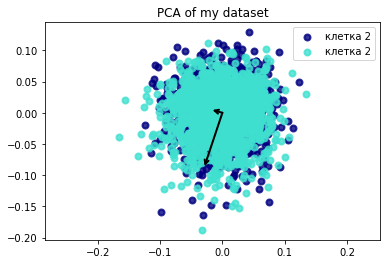

In [58]:
pca = PCA(n_components=2)

X_r = pca.fit(X_my_train).transform(X_my_train)

target_names = ["клетка 1", "клетка 2"]

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise']
lw = 2

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(np.array(X_my_train[y_my_train == 0])[:, 0], 
            np.array(X_my_train[y_my_train == 0])[:, 1], color='navy', alpha=.8, lw=lw,
                label=target_name)
plt.scatter(np.array(X_my_train[y_my_train == 1])[:, 0], 
            np.array(X_my_train[y_my_train == 1])[:, 1], color='turquoise', alpha=.8, lw=lw,
                label=target_name)
for length, vector in zip(pca.explained_variance_, pca.components_[:, :2]):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_[:2], pca.mean_[:2] + 3 * v)
plt.axis('equal')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of my dataset')

plt.show()

In [48]:
mean_X_my_train = X_my_train.mean(axis=0)

red = PCA()
X_my_train -= mean_X_my_train
red.fit(X_my_train)

PCA()

In [49]:
clf = LogisticRegression(solver="liblinear", random_state=0).fit(X_my_train, y_my_train)
roc_auc_score(y_my_test, clf.predict_proba(X_my_test)[:, 1])

0.7817592399972263

In [50]:
for i in range(10, 512, 10):
    clf = LogisticRegression(solver="liblinear", random_state=0).fit(red.transform(X_my_train)[:,:i], y_my_train)
    if roc_auc_score(y_my_test, clf.predict_proba(red.transform(X_my_test)[:,:i])[:, 1]) > 0.78:
        print(i)
        print(roc_auc_score(y_my_test, clf.predict_proba(red.transform(X_my_test)[:,:i])[:, 1]))
        print('-----')

370
0.7810369137600259
-----
380
0.7830652058340846
-----
390
0.7837759748514896
-----
400
0.7809155629521762
-----
410
0.7804763885999584
-----
420
0.7816205533596838
-----
430
0.780932898781869
-----
440
0.7802914730832351
-----
450
0.7815049811617318
-----
460
0.7811987148371587
-----
480
0.7816378891893766
-----
490
0.7827473822897164
-----
500
0.7823833298661675
-----
510
0.7825393523334028
-----


In [51]:
maxim = 0
ll = 0
for i in range(375, 395):
    clf = LogisticRegression(solver="liblinear", random_state=0).fit(red.transform(X_my_train)[:,:i], y_my_train)
    if roc_auc_score(y_my_test, clf.predict_proba(red.transform(X_my_test)[:,:i])[:, 1]) > maxim:
        maxim = roc_auc_score(y_my_test, clf.predict_proba(red.transform(X_my_test)[:,:i])[:, 1])
        ll = i
print(maxim)
print(ll)        

0.7852321845456858
388


Пока пробовал многое кроме ансамблей и бустинга, и PCA для лог рега показало лучший результат, долгое время (около недели) был в топ6 кагла с ним, но видимо пора уже переходить на бустинг... :)

PCA мега крут, очень хорошо что мы проходили и на лин але СВД, и на семинарах PCA

Из [учебника](https://ysda_trove.gitlab.io/ml-handbook/chapters/hyperparameters_tuning/intro) вы узнали о библиотеках подбора параметров hyperopt и optuna.
Попробуйте применить любую из них в следующем блоке заданий.

Возможно, вы захотите воспользоваться реализацией [Sequential Feature Selection из sklearn](https://scikit-learn.org/stable/modules/feature_selection.html#sequential-feature-selection) для реализации отбора признаков, методом добавления.

**Задание 3** (2.5 балла)
    Проведите отбор признаков, методом добавления, обучая KNN-классификатор.
    Подберите лучшие параметры на отобранных признаках.
    Проведите перестановочную оценку влияния отобранных признаков


In [18]:
# full_train.drop(columns = 'label'), full_train['label']
print(X_my_train.shape) # full -> X_my_train, X_my_test, y_my_train, y_my_test
print(X_my_cv_train.shape) # my_train -> X_my_cv_train, X_my_cv_test, y_my_cv_train, y_my_cv_test
X_my_train, X_my_test, y_my_train, y_my_test = train_test_split(full_train.drop(columns = 'label'),
                                                                full_train['label'],
                                                                test_size=0.2, random_state=42)

(3328, 512)
(2662, 512)


In [30]:
tic_fwd = time()
knn = KNeighborsClassifier(n_neighbors=3)
mlextend_sfs_knn = SFS(estimator = knn, k_features=250, forward=True, 
                   floating=False, verbose=2, scoring='roc_auc', cv=2, n_jobs=-1)
mlextend_sfs_knn.fit(X_my_train, y_my_train)
toc_fwd = time()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:    0.5s finished

[2021-05-12 12:46:44] Features: 1/250 -- score: 0.5358386922933556[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 352 out of 511 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 511 out of 511 | elapsed:    0.5s finished

[2021-05-12 12:46:45] Features: 2/250 -- score: 0.5391519527034153[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 510 out of 510 | elapsed:    0.7s finished

[2021-05-12 12:46:45] Features: 3/250 -- score: 0.5495620124743008[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n

In [35]:
print(f"Done in {toc_fwd - tic_fwd:.3f}s")

Done in 1953.676s


In [32]:
best_indx_dt = 1
for i in mlextend_sfs_knn.get_metric_dict():
    if mlextend_sfs_knn.subsets_[i]['avg_score'] > \
            mlextend_sfs_knn.subsets_[best_indx_dt]['avg_score']:
        best_indx_dt = i

In [33]:
print('best combination (AUC: %.3f): %s\n' % (mlextend_sfs_knn.subsets_[best_indx_dt]['avg_score'], 
                        len(mlextend_sfs_knn.subsets_[best_indx_dt]['feature_names'])))

best combination (AUC: 0.716): 205



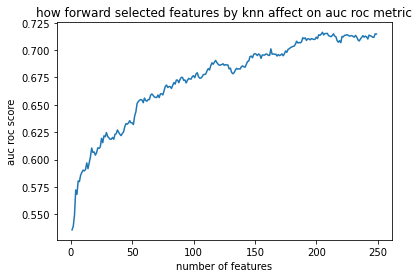

In [34]:
scores = [mlextend_sfs_knn.subsets_[i]['avg_score'] for i in 
          range(1, len(mlextend_sfs_knn.subsets_))]
plt.plot(range(1, len(mlextend_sfs_knn.subsets_)), scores)
plt.xlabel("number of features")
plt.ylabel("auc roc score")
plt.title("how forward selected features by knn affect on auc roc metric")
plt.show()

In [40]:
tic_fwd = time()
knn = KNeighborsClassifier(n_neighbors=3)
mlextend_sfs_knn_extended = SFS(estimator = knn, k_features=300, forward=True, 
                       fixed_features=mlextend_sfs_knn.k_feature_idx_,
                   floating=False, verbose=2, scoring='roc_auc', cv=2, n_jobs=-1)
mlextend_sfs_knn_extended.fit(X_my_train, y_my_train)
toc_fwd = time()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 235 out of 262 | elapsed:    7.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done 262 out of 262 | elapsed:    8.3s finished

[2021-05-12 13:49:15] Features: 251/300 -- score: 0.7167854041722592[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 233 out of 261 | elapsed:    6.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 261 out of 261 | elapsed:    6.8s finished

[2021-05-12 13:49:22] Features: 252/300 -- score: 0.7148418029222285[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 232 out of 260 | elapsed:    6.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 260 out of 260 | elapsed:    6.9

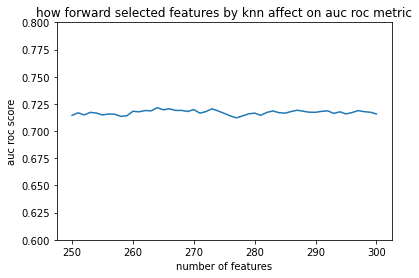

In [47]:
scores = [mlextend_sfs_knn_extended.subsets_[i]['avg_score'] for i in 
          range(250, 250 + len(mlextend_sfs_knn_extended.subsets_))]
plt.plot(range(250, 250 + len(mlextend_sfs_knn_extended.subsets_)), scores)
plt.xlabel("number of features")
plt.ylabel("auc roc score")
plt.ylim(0.6, 0.8)
plt.title("how forward selected features by knn affect on auc roc metric")
plt.show()

После 205 у нас был луший результат, поэтому и продолжим работать именно с тем набором фич. Иии, снова разорвало соединение с сервером.... (прямо после того как вывел этот прекрасные график выше). Поэтому выберем 205 фич снова и наверное мне придтся научиться работать с tmux, иначе далеко мы так не уедем :)

In [19]:
knn = KNeighborsClassifier(n_neighbors=3)
mlextend_sfs_knn = SFS(estimator = knn, k_features=205, forward=True, 
                   floating=False, verbose=2, scoring='roc_auc', cv=2, n_jobs=-1)
mlextend_sfs_knn.fit(X_my_train, y_my_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:    5.8s finished

[2021-05-12 14:05:54] Features: 1/205 -- score: 0.5358386922933556[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 352 out of 511 | elapsed:    2.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 511 out of 511 | elapsed:    2.8s finished

[2021-05-12 14:05:57] Features: 2/205 -- score: 0.5391519527034153[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 510 out of 510 | elapsed:    3.4s finished

[2021-05-12 14:06:01] Features: 3/205 -- score: 0.5495620124743008[Parallel(n_jobs=-1)]: Usi

SequentialFeatureSelector(cv=2, estimator=KNeighborsClassifier(n_neighbors=3),
                          k_features=205, n_jobs=-1, scoring='roc_auc',
                          verbose=2)

In [24]:
# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values for the hyperparameters using a trial object.
    classifier_name = trial.suggest_categorical('classifier', ['knn'])
    if classifier_name == 'knn':
        knn_nn = int(trial.suggest_uniform('knn_nn', 2, 5))
        classifier_obj = KNeighborsClassifier(n_neighbors=knn_nn)
        
    score = cross_val_score(classifier_obj,
                            mlextend_sfs_knn.transform(X_my_train),
                            y_my_train,
                            n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2021-05-12 14:36:41,270] A new study created in memory with name: no-name-7c609942-12b1-4ae5-8d97-2b5e84f3ca33
[I 2021-05-12 14:36:41,511] Trial 0 finished with value: 0.598255333782836 and parameters: {'classifier': 'knn', 'knn_nn': 2.637372662361423}. Best is trial 0 with value: 0.598255333782836.
[I 2021-05-12 14:36:41,736] Trial 1 finished with value: 0.6297982382743429 and parameters: {'classifier': 'knn', 'knn_nn': 4.900304106037953}. Best is trial 1 with value: 0.6297982382743429.
[I 2021-05-12 14:36:41,942] Trial 2 finished with value: 0.6466258864816123 and parameters: {'classifier': 'knn', 'knn_nn': 3.472114952998634}. Best is trial 2 with value: 0.6466258864816123.
[I 2021-05-12 14:36:42,149] Trial 3 finished with value: 0.6466258864816123 and parameters: {'classifier': 'knn', 'knn_nn': 3.761733909158291}. Best is trial 2 with value: 0.6466258864816123.
[I 2021-05-12 14:36:42,346] Trial 4 finished with value: 0.598255333782836 and parameters: {'classifier': 'knn', 'knn_nn

In [23]:
all_features = set(full_train.drop(columns = 'label').columns)
print(len(all_features))
taken_features_knn = mlextend_sfs_knn.subsets_[205]['feature_names']
not_taken_features_knn = all_features.difference(taken_features_knn)
print(taken_features_knn)

512
('A_001', 'A_002', 'A_005', 'A_011', 'A_012', 'A_019', 'A_021', 'A_023', 'A_024', 'A_025', 'A_027', 'A_029', 'A_033', 'A_034', 'A_035', 'A_037', 'A_040', 'A_042', 'A_045', 'A_050', 'A_053', 'A_056', 'A_057', 'A_060', 'A_065', 'A_067', 'A_068', 'A_070', 'A_071', 'A_072', 'A_077', 'A_078', 'A_081', 'A_084', 'A_085', 'A_087', 'A_092', 'A_094', 'A_095', 'A_099', 'A_100', 'A_101', 'A_102', 'A_104', 'A_111', 'A_112', 'A_113', 'A_114', 'A_116', 'A_120', 'A_121', 'A_123', 'A_124', 'A_126', 'A_127', 'A_129', 'A_130', 'A_133', 'A_137', 'A_139', 'A_142', 'A_143', 'A_150', 'A_152', 'A_153', 'A_157', 'A_159', 'A_167', 'A_170', 'A_171', 'A_173', 'A_175', 'A_178', 'A_179', 'A_181', 'A_182', 'A_188', 'A_189', 'A_190', 'A_191', 'A_196', 'A_199', 'A_208', 'A_212', 'A_213', 'A_214', 'A_215', 'A_216', 'A_217', 'A_220', 'A_221', 'A_222', 'A_223', 'A_224', 'A_225', 'A_226', 'A_229', 'A_232', 'A_234', 'A_237', 'A_240', 'A_241', 'A_243', 'A_248', 'A_249', 'A_252', 'A_253', 'A_254', 'A_256', 'A_263', 'A_26

#### Перестановочная оценка влияния выбранных признаков

In [10]:
model_knn = KNeighborsClassifier(n_neighbors=3).fit(X_my_train[taken_features_knn], y_my_train)

In [11]:
r = permutation_importance(model_knn, X_my_test[taken_features_knn], y_my_test,
                           n_repeats=5,
                           random_state=30, n_jobs = 32)

In [12]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{taken_features_knn[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

A_392   0.017 +/- 0.008
A_121   0.016 +/- 0.005
A_157   0.015 +/- 0.005
A_116   0.014 +/- 0.006
A_100   0.014 +/- 0.006
A_199   0.014 +/- 0.007
A_178   0.013 +/- 0.005
A_339   0.011 +/- 0.005
A_388   0.011 +/- 0.005
A_159   0.010 +/- 0.005
A_402   0.007 +/- 0.002
A_248   0.005 +/- 0.002
A_355   0.004 +/- 0.002


А вот это уже интересно, возможно взяв топ фич из каждых трёх заданий может получится что-то адекватное

**Задание 4** (2.5 балла)
    Проведите отбор признаков, методом добавления, обучая решающее дерево классификации.
    Подберите лучшие параметры на отобранных признаках.
    Проведите перестановочную оценку влияния отобранных признаков


In [19]:
# full_train.drop(columns = 'label'), full_train['label']
print(X_my_train.shape) # full -> X_my_train, X_my_test, y_my_train, y_my_test
print(X_my_cv_train.shape) # my_train -> X_my_cv_train, X_my_cv_test, y_my_cv_train, y_my_cv_test
X_my_train, X_my_test, y_my_train, y_my_test = train_test_split(full_train.drop(columns = 'label'),
                                                                full_train['label'],
                                                                test_size=0.2, random_state=42)

(3328, 512)
(2662, 512)


In [50]:
tic_fwd = time()
decision_tree = DecisionTreeClassifier()
mlextend_sfs_decision_tree = SFS(estimator = decision_tree, k_features=250, forward=True, 
                           floating=False, verbose=2, scoring='roc_auc', cv=2, n_jobs=-1)
mlextend_sfs_decision_tree.fit(X_my_train, y_my_train)
toc_fwd = time()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:    6.7s finished

[2021-05-12 11:05:15] Features: 1/250 -- score: 0.535020581007104[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 352 out of 511 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 511 out of 511 | elapsed:    1.2s finished

[2021-05-12 11:05:16] Features: 2/250 -- score: 0.5323646992023324[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 510 out of 510 | elapsed:    1.2s finished

[2021-05-12 11:05:18] Features: 3/250 -- score: 0.5387307969595878[Parallel(n_jobs=-1)]: Usin

In [55]:
print(f"Done in {toc_fwd - tic_fwd:.3f}s")

Done in 2967.308s


In [54]:
mlextend_sfs_decision_tree.subsets_[1]

{'feature_idx': (474,),
 'cv_scores': array([0.53346924, 0.53657192]),
 'avg_score': 0.535020581007104,
 'feature_names': ('A_474',)}

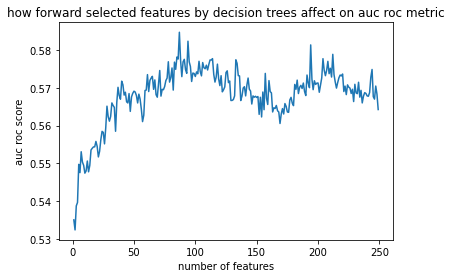

In [56]:
scores = [mlextend_sfs_decision_tree.subsets_[i]['avg_score'] for i in 
          range(1, len(mlextend_sfs_decision_tree.subsets_))]
plt.plot(range(1, len(mlextend_sfs_decision_tree.subsets_)), scores)
plt.xlabel("number of features")
plt.ylabel("auc roc score")
plt.title("how forward selected features by decision trees affect on auc roc metric")
plt.show()

In [73]:
best_indx_dt = 1
for i in mlextend_sfs_decision_tree.get_metric_dict():
    if mlextend_sfs_decision_tree.subsets_[i]['avg_score'] > \
            mlextend_sfs_decision_tree.subsets_[best_indx_dt]['avg_score']:
        best_indx_dt = i

In [74]:
print('best combination (AUC: %.3f): %s\n' % (mlextend_sfs_decision_tree.subsets_[best_indx_dt]['avg_score'], 
                        len(mlextend_sfs_decision_tree.subsets_[best_indx_dt]['feature_names'])))

best combination (AUC: 0.585): 87



Капец, дропнулось ядро, а обучать 250 фич ещё раз, это такая себе затея, в общем, решил довести снова до 87, и это просто вау, метод настолько нетсбальиный, что теперь 87 фич дают такой себе результат.

In [46]:
decision_tree = DecisionTreeClassifier()
tmp = SFS(estimator = decision_tree, k_features=87, forward=True, 
                           floating=False, verbose=2, scoring='roc_auc', cv=2, n_jobs=-1)
tmp.fit(X_my_train, y_my_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 206 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:    3.7s finished

[2021-05-12 14:45:49] Features: 1/87 -- score: 0.535020581007104[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 352 out of 511 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 511 out of 511 | elapsed:    0.7s finished

[2021-05-12 14:45:49] Features: 2/87 -- score: 0.5358733672087994[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 510 out of 510 | elapsed:    0.8s finished

[2021-05-12 14:45:50] Features: 3/87 -- score: 0.535066091833624[Parallel(n_jobs=-1)]: Using ba

SequentialFeatureSelector(cv=2, estimator=DecisionTreeClassifier(),
                          k_features=87, n_jobs=-1, scoring='roc_auc',
                          verbose=2)

In [47]:
# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values for the hyperparameters using a trial object.
    classifier_name = trial.suggest_categorical('classifier', ['dec_tr'])
    if classifier_name == 'dec_tr':
        dec_tr_max_dep = int(trial.suggest_uniform('dec_tr_max_dep', 2, 10))
        dec_tr_min_s_leaf = int(trial.suggest_uniform('dec_tr_min_s_leaf', 2, 40))
        classifier_obj_tr = DecisionTreeClassifier(max_depth = dec_tr_max_dep,
                                                   min_samples_leaf = dec_tr_min_s_leaf)
    
    scores = cross_validate(classifier_obj_tr, 
                            tmp.transform(X_my_train),
                            y_my_train,
                            cv=3, n_jobs=-1,
                            scoring='roc_auc',
                            return_train_score=True)
    my_score = scores['test_score'].mean()
    return my_score

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2021-05-12 14:54:36,783] A new study created in memory with name: no-name-bc924678-d4fc-428e-84fa-ce44d109f695
[I 2021-05-12 14:54:37,077] Trial 0 finished with value: 0.5082277560472281 and parameters: {'classifier': 'dec_tr', 'dec_tr_max_dep': 7.947895272071112, 'dec_tr_min_s_leaf': 31.72688199817405}. Best is trial 0 with value: 0.5082277560472281.
[I 2021-05-12 14:54:37,394] Trial 1 finished with value: 0.5086829626521461 and parameters: {'classifier': 'dec_tr', 'dec_tr_max_dep': 8.205790530619575, 'dec_tr_min_s_leaf': 6.4724711312535455}. Best is trial 1 with value: 0.5086829626521461.
[I 2021-05-12 14:54:37,684] Trial 2 finished with value: 0.5049120984407565 and parameters: {'classifier': 'dec_tr', 'dec_tr_max_dep': 7.118913244825443, 'dec_tr_min_s_leaf': 17.03988049254033}. Best is trial 1 with value: 0.5086829626521461.
[I 2021-05-12 14:54:37,887] Trial 3 finished with value: 0.5072561052350508 and parameters: {'classifier': 'dec_tr', 'dec_tr_max_dep': 8.016993873091888, 'd

In [48]:
all_features = set(full_train.drop(columns = 'label').columns)
print(len(all_features))
taken_features_decision_trees = tmp.subsets_[87]['feature_names']
not_taken_features_decision_trees = all_features.difference(taken_features_decision_trees)
print("Top: " + str(taken_features_decision_trees))

512
Top: ('A_002', 'A_004', 'A_011', 'A_014', 'A_016', 'A_032', 'A_043', 'A_046', 'A_057', 'A_058', 'A_064', 'A_074', 'A_078', 'A_088', 'A_089', 'A_091', 'A_098', 'A_108', 'A_109', 'A_125', 'A_127', 'A_128', 'A_136', 'A_142', 'A_160', 'A_164', 'A_169', 'A_180', 'A_186', 'A_197', 'A_202', 'A_205', 'A_207', 'A_209', 'A_217', 'A_219', 'A_227', 'A_229', 'A_231', 'A_238', 'A_240', 'A_243', 'A_248', 'A_249', 'A_257', 'A_271', 'A_302', 'A_305', 'A_311', 'A_314', 'A_317', 'A_323', 'A_325', 'A_328', 'A_340', 'A_346', 'A_349', 'A_353', 'A_354', 'A_359', 'A_364', 'A_367', 'A_374', 'A_379', 'A_381', 'A_386', 'A_398', 'A_407', 'A_415', 'A_417', 'A_418', 'A_419', 'A_422', 'A_428', 'A_431', 'A_436', 'A_449', 'A_452', 'A_456', 'A_462', 'A_463', 'A_465', 'A_474', 'A_475', 'A_496', 'A_501', 'A_510')


In [50]:
answer = list()
pre = set()
for i in range(1, 88):
    cur = set(tmp.subsets_[i]['feature_names']).difference(pre)
    answer.append(cur)
    pre.add(list(cur)[0])
print(answer)

[{'A_474'}, {'A_381'}, {'A_249'}, {'A_136'}, {'A_379'}, {'A_449'}, {'A_231'}, {'A_043'}, {'A_209'}, {'A_323'}, {'A_011'}, {'A_374'}, {'A_475'}, {'A_456'}, {'A_367'}, {'A_419'}, {'A_229'}, {'A_386'}, {'A_452'}, {'A_219'}, {'A_422'}, {'A_217'}, {'A_302'}, {'A_463'}, {'A_418'}, {'A_328'}, {'A_398'}, {'A_364'}, {'A_248'}, {'A_169'}, {'A_317'}, {'A_428'}, {'A_349'}, {'A_240'}, {'A_305'}, {'A_142'}, {'A_436'}, {'A_002'}, {'A_354'}, {'A_088'}, {'A_074'}, {'A_091'}, {'A_496'}, {'A_346'}, {'A_128'}, {'A_109'}, {'A_465'}, {'A_257'}, {'A_462'}, {'A_016'}, {'A_227'}, {'A_325'}, {'A_014'}, {'A_057'}, {'A_160'}, {'A_417'}, {'A_243'}, {'A_501'}, {'A_004'}, {'A_359'}, {'A_197'}, {'A_127'}, {'A_078'}, {'A_164'}, {'A_202'}, {'A_098'}, {'A_407'}, {'A_340'}, {'A_205'}, {'A_125'}, {'A_064'}, {'A_089'}, {'A_238'}, {'A_314'}, {'A_186'}, {'A_431'}, {'A_207'}, {'A_108'}, {'A_032'}, {'A_415'}, {'A_353'}, {'A_311'}, {'A_510'}, {'A_271'}, {'A_058'}, {'A_046'}, {'A_180'}]


#### Перестановочная оценка влияния выбранных признаков

In [13]:
model_dt = DecisionTreeClassifier(max_depth = 4, 
                                  min_samples_leaf = 10).fit(
    X_my_train[taken_features_dt], y_my_train)

In [14]:
r_dt = permutation_importance(model_dt, X_my_test[taken_features_dt], y_my_test,
                              n_repeats=5,
                              random_state=0)

In [15]:
for i in r_dt.importances_mean.argsort()[::-1]:
    if r_dt.importances_mean[i] - 2 * r_dt.importances_std[i] > 0:
        print(f"{taken_features_knn[i]:<8}"
              f"{r_dt.importances_mean[i]:.3f}"
              f" +/- {r_dt.importances_std[i]:.3f}")

A_033   0.004 +/- 0.000
A_012   0.003 +/- 0.001
A_137   0.002 +/- 0.001


3 фичи с такими результатами... Ну, от одного решающего дерева и не стоило ожидать чего-то серьёзного

**Задание 5** (2.5 балла)
    Подберите лучшие параметры для 
    Проведите отбор признаков, методом добавления, обучая классифкатор RandomForest .
    Подберите лучшие параметры на отобранных признаках.
    Проведите перестановочную оценку влияния отобранных признаков

In [21]:
# full_train.drop(columns = 'label'), full_train['label']
print(X_my_train.shape) # full -> X_my_train, X_my_test, y_my_train, y_my_test
print(X_my_cv_train.shape) # my_train -> X_my_cv_train, X_my_cv_test, y_my_cv_train, y_my_cv_test
X_my_train, X_my_test, y_my_train, y_my_test = train_test_split(full_train.drop(columns = 'label'),
                                                                full_train['label'],
                                                                test_size=0.2, random_state=42)

(3328, 512)
(2662, 512)


In [28]:
tic_fwd = time()
rf = RandomForestClassifier()
mlextend_sfs_rf = SFS(estimator = rf, k_features=150, forward=True, 
                   floating=False, verbose=2, scoring='roc_auc', cv=2, n_jobs=-1)
mlextend_sfs_rf.fit(X_my_train, y_my_train)
toc_fwd = time()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:   17.5s finished

[2021-05-12 16:23:39] Features: 1/150 -- score: 0.54086330425938[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 511 out of 511 | elapsed:   13.6s finished

[2021-05-12 16:23:53] Features: 2/150 -- score: 0.550432497330754[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 510 out of 510 | elapsed:   13.4s finished

[2021-05-12 16:24:06] Features: 3/150 -- score: 0.58

In [29]:
print(f"Done in {toc_fwd - tic_fwd:.3f}s")

Done in 4240.563s


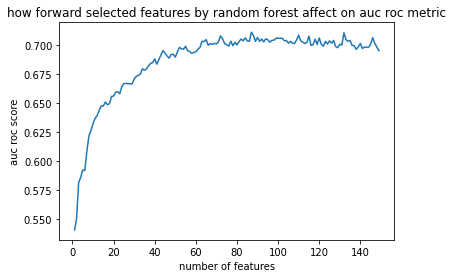

In [30]:
scores = [mlextend_sfs_rf.subsets_[i]['avg_score'] for i in 
          range(1, len(mlextend_sfs_rf.subsets_))]
plt.plot(range(1, len(mlextend_sfs_rf.subsets_)), scores)
plt.xlabel("number of features")
plt.ylabel("auc roc score")
plt.title("how forward selected features by random forest affect on auc roc metric")
plt.show()

In [31]:
best_indx_dt = 1
for i in mlextend_sfs_rf.get_metric_dict():
    if mlextend_sfs_rf.subsets_[i]['avg_score'] > \
            mlextend_sfs_rf.subsets_[best_indx_dt]['avg_score']:
        best_indx_dt = i

In [88]:
print('best combination (AUC: %.3f): %s\n' % (mlextend_sfs_rf.subsets_[best_indx_dt]['avg_score'], 
                        len(mlextend_sfs_rf.subsets_[best_indx_dt]['feature_names'])))

best combination (AUC: 0.711): 87



In [44]:
# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values for the hyperparameters using a trial object.
    classifier_name = trial.suggest_categorical('classifier', ['RandomForest'])
    if classifier_name == 'RandomForest':
        rf_max_depth = int(trial.suggest_loguniform('rf_max_depth', 2, 50))
        classifier_obj_rf = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=100, n_jobs = -1)
        
    scores = cross_validate(classifier_obj_rf, 
                            X_my_train[list(mlextend_sfs_rf.subsets_[best_indx_dt]['feature_names'])],
                            y_my_train,
                            cv=3, n_jobs=-1,
                            scoring='roc_auc',
                            return_train_score=True)
    my_score = scores['test_score'].mean()
    return my_score

    score = sklearn.model_selection.cross_val_score(classifier_obj_rf, x, y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2021-05-12 18:27:46,659] A new study created in memory with name: no-name-26f4943b-f7a5-4648-bfaa-b915a29e8597
[I 2021-05-12 18:27:53,393] Trial 0 finished with value: 0.7018452779150927 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 16.52617482349773}. Best is trial 0 with value: 0.7018452779150927.
[I 2021-05-12 18:27:56,368] Trial 1 finished with value: 0.6805899314870308 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 31.524719568323935}. Best is trial 0 with value: 0.7018452779150927.
[I 2021-05-12 18:27:59,527] Trial 2 finished with value: 0.70203394810144 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 16.663412492523015}. Best is trial 2 with value: 0.70203394810144.
[I 2021-05-12 18:28:02,563] Trial 3 finished with value: 0.690480125555834 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 27.6519003037115}. Best is trial 2 with value: 0.70203394810144.
[I 2021-05-12 18:28:05,655] Trial 4 finished with value: 0.69191

In [89]:
all_features = set(full_train.drop(columns = 'label').columns)
print(len(all_features))
taken_features_rf = mlextend_sfs_rf.subsets_[87]['feature_names']
not_taken_features_rf = all_features.difference(taken_features_rf)
print("Top: " + str(taken_features_rf))

512
Top: ('A_001', 'A_010', 'A_019', 'A_021', 'A_037', 'A_045', 'A_054', 'A_057', 'A_064', 'A_071', 'A_084', 'A_085', 'A_093', 'A_102', 'A_114', 'A_115', 'A_130', 'A_133', 'A_135', 'A_137', 'A_150', 'A_156', 'A_169', 'A_170', 'A_173', 'A_174', 'A_175', 'A_184', 'A_187', 'A_188', 'A_190', 'A_191', 'A_192', 'A_203', 'A_206', 'A_210', 'A_220', 'A_232', 'A_233', 'A_241', 'A_254', 'A_264', 'A_267', 'A_268', 'A_272', 'A_277', 'A_284', 'A_285', 'A_291', 'A_298', 'A_300', 'A_306', 'A_307', 'A_315', 'A_330', 'A_335', 'A_338', 'A_346', 'A_351', 'A_352', 'A_358', 'A_363', 'A_365', 'A_368', 'A_377', 'A_385', 'A_388', 'A_393', 'A_395', 'A_402', 'A_406', 'A_410', 'A_413', 'A_423', 'A_432', 'A_439', 'A_449', 'A_453', 'A_465', 'A_467', 'A_471', 'A_474', 'A_480', 'A_489', 'A_491', 'A_505', 'A_511')


#### Перестановочная оценка влияния выбранных признаков

In [17]:
model_rf = RandomForestClassifier(max_depth=8, n_estimators=100, n_jobs = -1).fit(
    X_my_train[taken_features_rf], y_my_train)

In [19]:
r_rf = permutation_importance(model_rf, X_my_test[taken_features_rf], y_my_test,
                           n_repeats=5,
                           random_state=0)

In [20]:
for i in r_rf.importances_mean.argsort()[::-1]:
    if r_rf.importances_mean[i] - 2 * r_rf.importances_std[i] > 0:
        print(f"{taken_features_knn[i]:<8}"
              f"{r_rf.importances_mean[i]:.3f}"
              f" +/- {r_rf.importances_std[i]:.3f}")

A_142   0.041 +/- 0.007
A_053   0.026 +/- 0.004
A_042   0.025 +/- 0.008
A_121   0.006 +/- 0.002
A_057   0.006 +/- 0.001
A_167   0.005 +/- 0.002
A_081   0.004 +/- 0.001
A_143   0.004 +/- 0.001
A_152   0.003 +/- 0.001


##### Комментарии:

Интересно заметить то, насколько разные результаты у всех этих алгоритмов, и как говорил админ в чатике по МЛ, результаты действительно не имеют стабильности, возможно больше из-за того, какие модели используются, но даже при изменении кол-ва скармливаемых данных результаты могут капец как измениться.

**Задание 6** (1.5 балла)
    При помощи библиотеки shap, отранжируйте признаки по степени их влияния для предсказаний модели из предыдущего пункта.
    Сопадает ли ранжирование по shap с ранжированием на основе перестановочных оценок? 
    
1. shap - https://towardsdatascience.com/a-novel-approach-to-feature-importance-shapley-additive-explanations-d18af30fc21b

In [8]:
taken_features_rf = ['A_001', 'A_010', 'A_019', 'A_021', 'A_037', 'A_045', 'A_054', 'A_057', 'A_064',
                                 'A_071', 'A_084', 'A_085', 'A_093', 'A_102', 'A_114', 'A_115', 'A_130', 'A_133',
                                 'A_135', 'A_137', 'A_150', 'A_156', 'A_169', 'A_170', 'A_173', 'A_174', 'A_175',
                                 'A_184', 'A_187', 'A_188', 'A_190', 'A_191', 'A_192', 'A_203', 'A_206', 'A_210',
                                 'A_220', 'A_232', 'A_233', 'A_241', 'A_254', 'A_264', 'A_267', 'A_268', 'A_272',
                                 'A_277', 'A_284', 'A_285', 'A_291', 'A_298', 'A_300', 'A_306', 'A_307', 'A_315',
                                 'A_330', 'A_335', 'A_338', 'A_346', 'A_351', 'A_352', 'A_358', 'A_363', 'A_365',
                                 'A_368', 'A_377', 'A_385', 'A_388', 'A_393', 'A_395', 'A_402', 'A_406', 'A_410',
                                 'A_413', 'A_423', 'A_432', 'A_439', 'A_449', 'A_453', 'A_465', 'A_467', 'A_471',
                                 'A_474', 'A_480', 'A_489', 'A_491', 'A_505', 'A_511']

In [69]:
model = RandomForestClassifier(n_estimators=1000, max_depth = 8, n_jobs = -1)
model.fit(X_my_train[list(taken_features_rf)],
          y_my_train,)

RandomForestClassifier(max_depth=8, n_estimators=1000, n_jobs=-1)

In [72]:
# full_train.drop(columns = 'label'), full_train['label']
print(X_my_train.shape) # full -> X_my_train, X_my_test, y_my_train, y_my_test
print(X_my_cv_train.shape) # my_train -> X_my_cv_train, X_my_cv_test, y_my_cv_train, y_my_cv_test
X_my_train, X_my_test, y_my_train, y_my_test = train_test_split(full_train.drop(columns = 'label'),
                                                                full_train['label'],
                                                                test_size=0.2, random_state=42)

(3328, 512)
(2662, 512)


In [73]:
shap.initjs()

In [75]:
# model - random forest обученная на всех отобранных в предыдщем задании
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_my_train[list(taken_features_rf)], y_my_train)

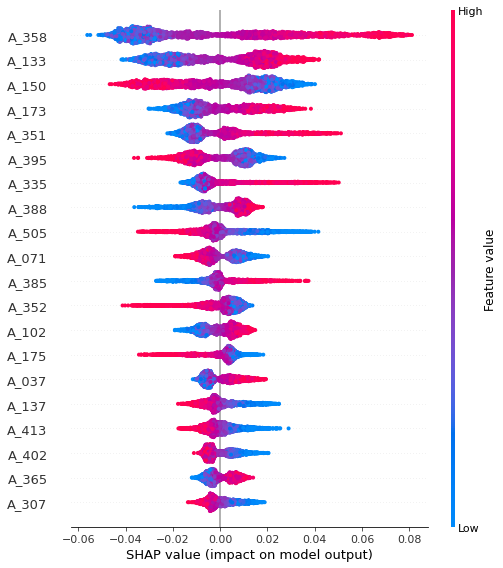

In [78]:
shap.summary_plot(shap_values[1], X_my_train[list(taken_features_rf)], 
                  feature_names=list(taken_features_rf))

Первый график показывает как на первом объекте повлияла каждая фича.

Второй график показывает хорошую информацию для сравнения фич друг с другом по важности предсказания класса 1, но не показывает бесоплезна ли фича. С курса на кагле про shap summary plot:
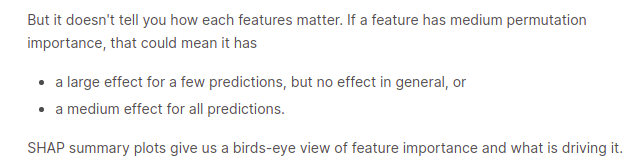

Ранжирование совпасть не должно, так как сами методы разные:

1. shap - Shapley Additive Explanations - по своей сути смотрит как каждая фича влияет на каждый объект! а не сразу на всю совокупность. По сути, он смотрит как мы справляемся без этой фичи, и вместе с ней, и смотрим какой она даёт вклад для каждого объекта отдельно! 
    1.1 А если хотим посмотреть её общее вложение в группу объектов, то усреднить результаты фичи по объектам будет не совсем то, ведь так мы не учтём дисперсию, но можно сделать график всех фич по всем объектам, где будет видно как каждая фича (насколько велика дисперсия) влияет на объекты выбокри. 
    1.2 Либо взять среднее по модулям.
    
    
2. SFS - смотрит на общее влияние фич на оценку модели и изменения метрики, а не на отдельные объекты. Плюс ну нереально долгий метод требущий качество на кросс-валидации на каждой своей итерации, строит просто уйму моделей, что отличияет его почти от всех остальных методов выборов фичей. При том как должно быть видно по результатам задач 3-5, он ещё и соверешнно не стабилен.

**Задание 7** (1.5 балла)
    Обучите классификатор RandomForest на всех признаках
    Попробуйте выкинуть хвост из "не влияющих" признаков.
    Что произойдет с качеством?
    Как пересекаются множества "выкинутых" факторов и факторов, которые не были добавлены в прошлом задании?

In [22]:
# full_train.drop(columns = 'label'), full_train['label']
print(X_my_train.shape) # full -> X_my_train, X_my_test, y_my_train, y_my_test
print(X_my_cv_train.shape) # my_train -> X_my_cv_train, X_my_cv_test, y_my_cv_train, y_my_cv_test
X_my_train, X_my_test, y_my_train, y_my_test = train_test_split(full_train.drop(columns = 'label'),
                                                                full_train['label'],
                                                                test_size=0.2, random_state=42)

(3328, 512)
(2662, 512)


In [23]:
clf_rf = RandomForestClassifier(n_estimators=1000, max_depth = 8, n_jobs = -1)
clf_rf.fit(X_my_train, y_my_train)

RandomForestClassifier(max_depth=8, n_estimators=1000, n_jobs=-1)

In [24]:
feature_imp = pd.Series(clf_rf.feature_importances_, 
                        index=full_train.drop(columns = 'label').columns).sort_values(ascending=False)
feature_imp

A_358    0.019019
A_150    0.009523
A_133    0.009007
A_173    0.006897
A_351    0.006718
           ...   
A_123    0.001237
A_112    0.001218
A_492    0.001207
A_209    0.001201
A_077    0.001191
Length: 512, dtype: float64

No handles with labels found to put in legend.


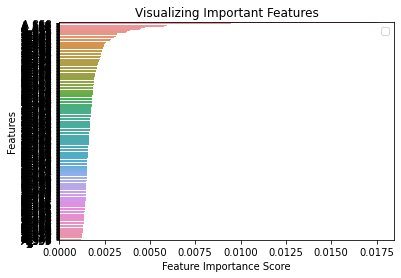

In [87]:
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [122]:
auc_roc_scores_over_features = list()

for i in range(1, 512, 10):
    clf = RandomForestClassifier(n_estimators=250, random_state=1, n_jobs=32)
    clf.fit(X_my_train[feature_imp.index[:i]], y_my_train)
    auc_roc_scores_over_features.append(
        roc_auc_score(y_my_test, clf.predict_proba(X_my_test[feature_imp.index[:i]])[:, 1]))

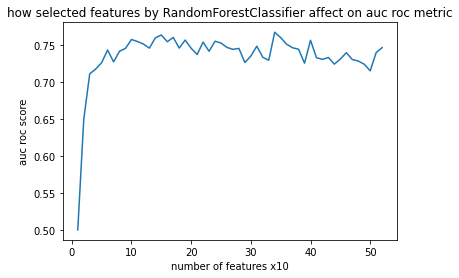

In [125]:
plt.plot(range(1, len(auc_roc_scores_over_features) + 1), auc_roc_scores_over_features)
plt.xlabel("number of features x10")
plt.ylabel("auc roc score")
plt.title("how selected features by RandomForestClassifier affect on auc roc metric")
plt.show()

In [124]:
print(np.argmax(auc_roc_scores_over_features))

33


In [118]:
clf_rf_all = RandomForestClassifier(n_estimators=3000, random_state=1, n_jobs=32)
clf_rf_all.fit(X_my_train, y_my_train)

RandomForestClassifier(n_estimators=3000, n_jobs=32, random_state=1)

In [119]:
print("all features")
roc_auc_score(y_my_test, clf_rf_all.predict_proba(X_my_test)[:, 1])

all features


0.7744630484988453

In [152]:
clf_rf_85 = RandomForestClassifier(n_estimators=250, random_state=1, n_jobs=32)
clf_rf_85.fit(X_my_train[feature_imp[: 151].index], y_my_train)

RandomForestClassifier(n_estimators=250, n_jobs=32, random_state=1)

In [153]:
print("selected 150 features")
roc_auc_score(y_my_test, clf_rf_85.predict_proba(X_my_test[feature_imp.index[: 151]])[:, 1])

selected 150 features


0.7550187226960683

In [130]:
clf_rf_145 = RandomForestClassifier(n_estimators=250, random_state=1, n_jobs=32)
clf_rf_145.fit(X_my_train[feature_imp.index[: 331]], y_my_train)

RandomForestClassifier(n_estimators=250, n_jobs=32, random_state=1)

In [131]:
print("selected 330 features")
roc_auc_score(y_my_test, clf_rf_145.predict_proba(X_my_test[feature_imp[: 331].index])[:, 1])

selected 330 features


0.767789450569771

In [154]:
clf_rf_85 = RandomForestClassifier(n_estimators=3000, random_state=1, n_jobs=32)
clf_rf_85.fit(X_my_train[feature_imp[: 151].index], y_my_train)

RandomForestClassifier(n_estimators=3000, n_jobs=32, random_state=1)

In [156]:
print("selected 150 features, 3000 estim")
roc_auc_score(y_my_test, clf_rf_85.predict_proba(X_my_test[feature_imp.index[: 151]])[:, 1])

selected 150 features, 3000 estim


0.7770381157108845

In [157]:
clf_rf_145 = RandomForestClassifier(n_estimators=3000, random_state=1, n_jobs=32)
clf_rf_145.fit(X_my_train[feature_imp.index[: 331]], y_my_train)
print("selected 330 features, 3000 estim")
roc_auc_score(y_my_test, clf_rf_145.predict_proba(X_my_test[feature_imp[: 331].index])[:, 1])

selected 330 features, 3000 estim


0.7844607401243556

Йхохо, rf на 330 лучших фичах уделал лог рег, это первая модель, которая смогла! (n_estimators = 3000 сильно помог)

Удаляя "хвостовые" признаки качество начало расти (видно из выводов выше). Но со временем фичи уже толком ничего не давали. На самом деле я ещё заметил такую тенденцию, что если увеличивать кол-во n_estimators, то всё больше и больше фич становятся очень полезными (для 100 деревьев в  rf - 88 деревьев давали лучший результат, для 250 деревьев - на графкие 150 фич уже нужно, а не 88)

In [140]:
print(len(taken_features_rf))

87


In [159]:
all_features = set(full_train.drop(columns = 'label').columns)
not_taken_features_rf = all_features.difference(taken_features_rf)
len(set(feature_imp[151: ].index).intersection(not_taken_features_rf))

316

In [165]:
print("sfs rf took 87, and left    " + str(512 - 87))
print("rf took 151 (чтобы лучше чекнуть беру 150, а не 330, " + 
      "т.к. значения не большие а инфу для задания куда качественне поулчим), and left          " + 
      str(512 - 151))
print("фич, что оставлены обоими алго " + str(316))

sfs rf took 87, and left    425
rf took 151 (чтобы лучше чекнуть беру 150, а не 330, т.к. значения не большие а инфу для задания куда качественне поулчим), and left          361
фич, что оставлены обоими алго 316


Видно, что очень бльшое кол-во фич, которые оба алгоритма не взяли, следовательно можно действительно подумать о том, чтобы выкинуть их, потому что непосредственно для random forest-a без них результаты были сильно лучше, пожалуй одна из этих моделей пойдёт для ансамбля на кагл.

**Задание 8** (1 балл)
    Сравните модели из заданий 3,4,5

Сравним, что за фичи они выбирали, насколько сильно перескаются множества:

In [7]:
taken_features_knn = ['A_001', 'A_002', 'A_005', 'A_011', 'A_012', 'A_019', 'A_021', 'A_023', 'A_024', 'A_025', 'A_027', 'A_029', 'A_033', 'A_034', 'A_035', 'A_037', 'A_040', 'A_042', 'A_045', 'A_050', 'A_053', 'A_056', 'A_057', 'A_060', 'A_065', 'A_067', 'A_068', 'A_070', 'A_071', 'A_072', 'A_077', 'A_078', 'A_081', 'A_084', 'A_085', 'A_087', 'A_092', 'A_094', 'A_095', 'A_099', 'A_100', 'A_101', 'A_102', 'A_104', 'A_111', 'A_112', 'A_113', 'A_114', 'A_116', 'A_120', 'A_121', 'A_123', 'A_124', 'A_126', 'A_127', 'A_129', 'A_130', 'A_133', 'A_137', 'A_139', 'A_142', 'A_143', 'A_150', 'A_152', 'A_153', 'A_157', 'A_159', 'A_167', 'A_170', 'A_171', 'A_173', 'A_175', 'A_178', 'A_179', 'A_181', 'A_182', 'A_188', 'A_189', 'A_190', 'A_191', 'A_196', 'A_199', 'A_208', 'A_212', 'A_213', 'A_214', 'A_215', 'A_216', 'A_217', 'A_220', 'A_221', 'A_222', 'A_223', 'A_224', 'A_225', 'A_226', 'A_229', 'A_232', 'A_234', 'A_237', 'A_240', 'A_241', 'A_243', 'A_248', 'A_249', 'A_252', 'A_253', 'A_254', 'A_256', 'A_263', 'A_264', 'A_266', 'A_269', 'A_271', 'A_276', 'A_281', 'A_282', 'A_283', 'A_285', 'A_291', 'A_292', 'A_294', 'A_295', 'A_298', 'A_301', 'A_303', 'A_305', 'A_308', 'A_309', 'A_311', 'A_313', 'A_314', 'A_316', 'A_317', 'A_320', 'A_323', 'A_324', 'A_329', 'A_336', 'A_339', 'A_346', 'A_350', 'A_351', 'A_355', 'A_356', 'A_358', 'A_359', 'A_362', 'A_364', 'A_365', 'A_366', 'A_371', 'A_373', 'A_374', 'A_378', 'A_381', 'A_385', 'A_386', 'A_388', 'A_391', 'A_392', 'A_395', 'A_396', 'A_399', 'A_402', 'A_404', 'A_406', 'A_407', 'A_409', 'A_411', 'A_416', 'A_418', 'A_421', 'A_423', 'A_426', 'A_428', 'A_431', 'A_432', 'A_434', 'A_436', 'A_439', 'A_441', 'A_442', 'A_447', 'A_449', 'A_451', 'A_454', 'A_458', 'A_462', 'A_463', 'A_473', 'A_474', 'A_476', 'A_480', 'A_482', 'A_489', 'A_493', 'A_494', 'A_497', 'A_498', 'A_500', 'A_501', 'A_502', 'A_505', 'A_509']
taken_features_dt = ['A_002', 'A_004', 'A_011', 'A_014', 'A_016', 'A_032', 'A_043', 'A_046', 'A_057', 'A_058', 'A_064', 'A_074', 'A_078', 'A_088', 'A_089', 'A_091', 'A_098', 'A_108', 'A_109', 'A_125', 'A_127', 'A_128', 'A_136', 'A_142', 'A_160', 'A_164', 'A_169', 'A_180', 'A_186', 'A_197', 'A_202', 'A_205', 'A_207', 'A_209', 'A_217', 'A_219', 'A_227', 'A_229', 'A_231', 'A_238', 'A_240', 'A_243', 'A_248', 'A_249', 'A_257', 'A_271', 'A_302', 'A_305', 'A_311', 'A_314', 'A_317', 'A_323', 'A_325', 'A_328', 'A_340', 'A_346', 'A_349', 'A_353', 'A_354', 'A_359', 'A_364', 'A_367', 'A_374', 'A_379', 'A_381', 'A_386', 'A_398', 'A_407', 'A_415', 'A_417', 'A_418', 'A_419', 'A_422', 'A_428', 'A_431', 'A_436', 'A_449', 'A_452', 'A_456', 'A_462', 'A_463', 'A_465', 'A_474', 'A_475', 'A_496', 'A_501', 'A_510']
taken_features_rf = ['A_001', 'A_010', 'A_019', 'A_021', 'A_037', 'A_045', 'A_054', 'A_057', 'A_064',
                                 'A_071', 'A_084', 'A_085', 'A_093', 'A_102', 'A_114', 'A_115', 'A_130', 'A_133',
                                 'A_135', 'A_137', 'A_150', 'A_156', 'A_169', 'A_170', 'A_173', 'A_174', 'A_175',
                                 'A_184', 'A_187', 'A_188', 'A_190', 'A_191', 'A_192', 'A_203', 'A_206', 'A_210',
                                 'A_220', 'A_232', 'A_233', 'A_241', 'A_254', 'A_264', 'A_267', 'A_268', 'A_272',
                                 'A_277', 'A_284', 'A_285', 'A_291', 'A_298', 'A_300', 'A_306', 'A_307', 'A_315',
                                 'A_330', 'A_335', 'A_338', 'A_346', 'A_351', 'A_352', 'A_358', 'A_363', 'A_365',
                                 'A_368', 'A_377', 'A_385', 'A_388', 'A_393', 'A_395', 'A_402', 'A_406', 'A_410',
                                 'A_413', 'A_423', 'A_432', 'A_439', 'A_449', 'A_453', 'A_465', 'A_467', 'A_471',
                                 'A_474', 'A_480', 'A_489', 'A_491', 'A_505', 'A_511']

In [56]:
print("sfs knn took = " + str(len(taken_features_knn)) + ", and left = " + str(512 - len(taken_features_knn)))
print("sfs dt took =  " + str(len(taken_features_dt)) + ", and left = " + str(512 - len(taken_features_dt)))
print("sfs rf took =  " + str(len(taken_features_rf)) + ", and left = " + str(512 - len(taken_features_rf)))
print("intersection between all: " + str(len(set(taken_features_knn).intersection(taken_features_dt).
                                            intersection(taken_features_rf))))
print("intersection between knn and dt: " + str(len(set(taken_features_knn).intersection(taken_features_dt))))
print("intersection between knn and rf: " + str(len(set(taken_features_knn).intersection(taken_features_rf))))
print("intersection between rf and dt:  " + str(len(set(taken_features_rf).intersection(taken_features_dt))))

sfs knn took = 205, and left = 307
sfs dt took =  87, and left = 425
sfs rf took =  87, and left = 425
intersection between all: 4
intersection between knn and dt: 34
intersection between knn and rf: 46
intersection between rf and dt:  7


Достаточно разные результаты у sfs

Так же в ходе исследований были получены следующие результаты:
* knn - 0.71       (в выводах 3го задания)
* dt  - 0.58       (в выводах 4го задания)
* rf  - 0.71       (в выводах 5го задания)
* rf  - 0.784      (лучший результат - задание 7)
* log reg - 0.74   (лучший результат в личных экспериментах)

Хотя на самой тестовой выборке, что на кагле публичная, лог рег показывает аж 0.79, и сильно превосходит лучший rf

1) knn - 0.71 - это лучший результат, но на самом деле мне с ним сильно повезло. Долгое время не мог получить такой результат, т.к.: начал просто смотреть изменения knn результатов для разных random_state-ов в разбиении, и получилось, что он летает от 0.62 до 0.71. Вывод для себя - делать cv = 2 для ускорения работы не самое разумное решение :). Но после долшло до более интересных результатов, они показаны в след блоке

2) dt - ожидаемый плохой результат, т.к. они сильно переобучаются, и даже тюнинг не помог найти нормальные парметры для дерева, чтобы оно начало показывать приемлимый результат на тестовой выборке

3) rf - ожидаемо, что результат будет сильно выше чем у dt за счёт того, что это ансамбль решающих деревьев (причины следуют из расписанного bias variance decomposition, как будет оно меняться при усреднении результата большого кол-ва переобученных решающих деревьях с различным выбором фич)

In [210]:
best_min = 1.0
best_max = 0.0
meann = 0.0
for i in range(42):
    X_my_train, X_my_test, y_my_train, y_my_test = train_test_split(full_train.drop(columns = 'label'),
                                                                full_train['label'],
                                                                test_size=0.1, random_state=i)
    model = KNeighborsClassifier(n_neighbors=3)
    model.fit(X_my_train[feature_imp[: 331].index], y_my_train)
    cur = roc_auc_score(y_my_test, model.predict_proba(X_my_test[feature_imp[: 331].index])[:, 1])
    best_min = min(best_min, cur)
    best_max = max(best_max, cur)
    meann += cur
meann = meann / 42
print("best_min " + str(best_min))
print("best_max " + str(best_max))
print("meann " + str(meann))

best_min 0.6340924775707384
best_max 0.7385526921306949
meann 0.6932085058762707


Хммм, всё таки knn не так плох, метрически тоже получилось взять классный результат, а как было в 11 семинаре, мы взяли knn с просто ужасными результатами, порядка 0.6, к svm у которого было 0.81, и ансамбль (стэкинг) помог нам просто функцией из коробки поднять значение до 0.86. Так что мы сохраним для себя какую-нибудь хорошую модель из knn, mean значение не сильно отстаёт от лог рега так то.

Посмотрим что нам дадут ExtraTrees со всеми фичами, а потом с теми, что выделил RF

In [206]:
ex_tr = ExtraTreesClassifier(n_estimators=3000, random_state=32).fit(X_my_train, y_my_train)

In [211]:
roc_auc_score(y_my_test, ex_tr.predict_proba(X_my_test)[:, 1])

0.7972395472395473

In [213]:
ex_tr = ExtraTreesClassifier(n_estimators=3000, random_state=32).fit(X_my_train[feature_imp[: 331].index],
                                                                     y_my_train)

In [214]:
roc_auc_score(y_my_test, ex_tr.predict_proba(X_my_test[feature_imp[: 331].index])[:, 1])

0.8041118041118042

In [215]:
ex_tr = ExtraTreesClassifier(n_estimators=3000, random_state=32).fit(X_my_train[feature_imp[: 151].index],
                                                                     y_my_train)

In [216]:
roc_auc_score(y_my_test, ex_tr.predict_proba(X_my_test[feature_imp[: 151].index])[:, 1])

0.7965465465465466

Теперь понятно почему после семинара по extra trees и ансамблям у Саши пошли результаты вверх. Возьмём себе на заметочку :)

P.S Никакой алгоритм не давал результатов такого порядка

Ееееее, был топ20 с лог регом, стал топ 12 с extra trees, а уже так то 50 человек тута. Но вот такой момент разве что, что на всех фичах экстра деревья показали лучше результат. Я на семинаре подробно описывал отличия от random forest и как бы для них это нормально) просто щя надо подумать стоит ли убирать какие-то фичи из экстра деревье в впринципе, для ансамбля имею ввиду.

**Задание 9** (2 балла)
    Постройте линейный ансамбль из лучших моделей.

In [117]:
# full_train.drop(columns = 'label'), full_train['label']
print(X_my_train.shape) # full -> X_my_train, X_my_test, y_my_train, y_my_test
print(X_my_cv_train.shape) # my_train -> X_my_cv_train, X_my_cv_test, y_my_cv_train, y_my_cv_test
X_my_train, X_my_test, y_my_train, y_my_test = train_test_split(full_train.drop(columns = 'label'),
                                                                full_train['label'],
                                                                test_size=0.2, random_state=30)

(3328, 512)
(2662, 512)


In [126]:
from itertools import combinations

In [36]:
def stacking_cheker(X_train, y_train, X_test, y_test, models, features=None):
    # models - extra, rf, knn, logreg
    # TO DO
    for l in range(2, len(models) + 1):
        for i in combinations(models, l):
            estimators = []
            for m in i:
                if 'extra' in m:
                    estimators.append(('extra', ExtraTreesClassifier(n_estimators=3000, random_state=32, n_jobs=64)))
                if 'knn' in m:
                    estimators.append(('knn', KNeighborsClassifier(n_neighbors=3, n_jobs=64)))
                if 'logreg' in m:
                    estimators.append(('logreg', LogisticRegression(solver='liblinear')))                  
                if 'rf' in m:
                    estimators.append(('rf', RandomForestClassifier(n_estimators=3000, random_state=32, n_jobs=64)))
            
            clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
            fitted_clf = clf.fit(X_train, y_train)
            print("combination: " + str(i))
            auc_score = roc_auc_score(y_test, fitted_clf.predict_proba(X_test)[:, 1])
            print("auc score: " + str(auc_score))
            print("------------------------------------------")

In [130]:
stacking_cheker(X_my_train, y_my_train, X_my_test, y_my_test, ["extra", "knn", "logreg", "rf"])

combination: ('extra', 'knn')
auc score: 0.7996102771362588
------------------------------------------
combination: ('extra', 'logreg')
auc score: 0.8021709006928406
------------------------------------------
combination: ('extra', 'rf')
auc score: 0.7890531177829099
------------------------------------------
combination: ('knn', 'logreg')
auc score: 0.8300577367205544
------------------------------------------
combination: ('knn', 'rf')
auc score: 0.8073960739030022
------------------------------------------
combination: ('logreg', 'rf')
auc score: 0.8044110854503466
------------------------------------------
combination: ('extra', 'knn', 'logreg')
auc score: 0.8317147806004619
------------------------------------------
combination: ('extra', 'knn', 'rf')
auc score: 0.8172459584295613
------------------------------------------
combination: ('extra', 'logreg', 'rf')
auc score: 0.8052829099307159
------------------------------------------
combination: ('knn', 'logreg', 'rf')
auc score: 

Топ 9 кагла из 50 человек после этого, почти 0.82 набрал, стэкинг нереально сильный буст дал.

https://www.kaggle.com/prashant111/stacked-classifier-top-10-on-lb

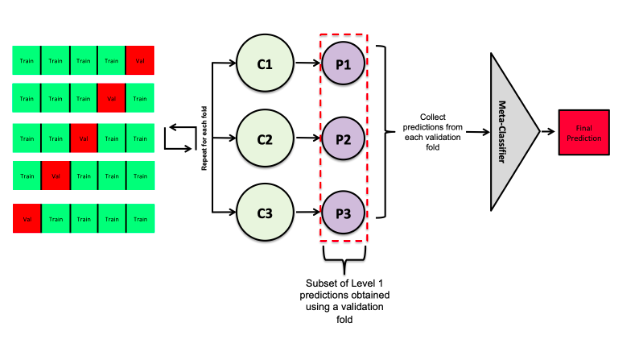

**Задание 10** (2 балла)
    Постройте ансамбль из лучших моделей при помощи какой-либо реализации GBDT, например -- lightgbm или catboost

In [1]:
import xgboost
import catboost
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier, XGBRFClassifier, DMatrix

## CatBoost and XGBoost Classifiers для стэкинга

In [8]:
estimators = []
estimators.append(('extra', ExtraTreesClassifier(n_estimators=100, random_state=32, n_jobs=-1)))
estimators.append(('knn', KNeighborsClassifier(n_neighbors=3, n_jobs=64)))
estimators.append(('logreg', LogisticRegression(solver='liblinear')))                  
estimators.append(('rf', RandomForestClassifier(n_estimators=100, random_state=32, n_jobs=32)))
clf = StackingClassifier(estimators=estimators, final_estimator=CatBoostClassifier(
    iterations=10,
    random_seed=42,
    learning_rate=0.1,
    custom_loss=['AUC'], verbose=True
))
fitted_clf = clf.fit(X_my_train, y_my_train)
print("extra knn logred rf-> CatBoost Classifier: ")
auc_score = roc_auc_score(y_my_test, fitted_clf.predict_proba(X_my_test)[:, 1])
print("auc score: " + str(auc_score))
print("------------------------------------------")

0:	learn: 0.6715253	total: 58ms	remaining: 522ms
1:	learn: 0.6540351	total: 63.4ms	remaining: 253ms
2:	learn: 0.6380471	total: 66.6ms	remaining: 155ms
3:	learn: 0.6247929	total: 69.3ms	remaining: 104ms
4:	learn: 0.6131942	total: 72.1ms	remaining: 72.1ms
5:	learn: 0.6037910	total: 74.9ms	remaining: 49.9ms
6:	learn: 0.5953977	total: 77.1ms	remaining: 33.1ms
7:	learn: 0.5888816	total: 79.4ms	remaining: 19.8ms
8:	learn: 0.5827335	total: 81.7ms	remaining: 9.08ms
9:	learn: 0.5775622	total: 84ms	remaining: 0us
extra knn logred rf-> CatBoost Classifier: 
auc score: 0.8042524790236462
------------------------------------------


In [9]:
estimators = []
estimators.append(('extra', ExtraTreesClassifier(n_estimators=100, random_state=32, n_jobs=-1)))
estimators.append(('knn', KNeighborsClassifier(n_neighbors=3, n_jobs=64)))
estimators.append(('logreg', LogisticRegression(solver='liblinear')))                  
estimators.append(('rf', RandomForestClassifier(n_estimators=100, random_state=32, n_jobs=32)))
clf = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(objective="binary:logistic", 
                                                                              n_jobs = 64,
                         tree_method="exact",
                         learning_rate=0.1,
                         eval_set=(X_my_test, y_my_test),
                         eval_metric='auc',
                         verbose=2))
fitted_clf = clf.fit(X_my_train, y_my_train)
print("extra knn logred rf-> XGB Classifier: ")
auc_score = roc_auc_score(y_my_test, fitted_clf.predict_proba(X_my_test)[:, 1])
print("auc score: " + str(auc_score))
print("------------------------------------------")

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[19:29:09] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


extra knn logred rf-> XGB Classifier: 
auc score: 0.7916175484825371
------------------------------------------


## CatBoost and XGBoost Classifiers из коробки

In [131]:
X_my_train, X_my_test, y_my_train, y_my_test = train_test_split(full_train.drop(columns = 'label'),
                                                                full_train['label'],
                                                                test_size=0.2, random_state=42)
print(X_my_train.shape) # full -> X_my_train, X_my_test, y_my_train, y_my_test

X_my_cv_train, X_my_cv_test, y_my_cv_train, y_my_cv_test = train_test_split(X_my_train,
                                                                y_my_train,
                                                                test_size=0.2, random_state=42)
print(X_my_cv_train.shape) # my_train -> X_my_cv_train, X_my_cv_test, y_my_cv_train, y_my_cv_test

(3328, 512)
(2662, 512)


In [51]:
clf = CatBoostClassifier(
    iterations=1500,
    random_seed=42,
    learning_rate=0.1,
    custom_loss=['AUC:hints=skip_train~false']
)

clf.fit(
    X_my_train, y_my_train,
    eval_set=(X_my_test, y_my_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [108]:
clf_xgrf = XGBClassifier(objective="binary:logistic", n_jobs = 64,
                         tree_method="exact",
                         learning_rate=0.1,
                         eval_set=(X_my_test, y_my_test),
                         eval_metric='auc',
                         verbose=2)

clf_xgrf.fit(X_my_train, y_my_train)

[18:18:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              eval_set=(         A_000     A_001     A_002     A_003     A_004     A_005     A_006  \
3540  1.002192  0.987751  0.837961  1.045943  0.970153  0.899871  0.840885   
3176  0.925072  0.941367  1.004408  1.067080  0.934803  0.849733  0.989299   
175   0.935102  0.885063  0.997511  1.073979  1.022357  0.879308  0.922334   
305...
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=64,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbose=2, verbosity=None)

In [110]:
roc_auc_score(y_my_test, clf_xgrf.predict_proba(X_my_test)[:, 1])

0.746723528188059

**Задание 11** (1 балл)
    Сделайте вывод, помогло ли ансамблирование победить лучшие модели. В чем могут быть причины?

1) Градиентный бустинг над стэкингом - есть трудности, т.к. он улучшает лог лосс, а не всегда луучшение лог лосса улучшает рок аук. И это капец как долго обучается. Хотя я ещё попробую использовать различные бустинга как финальные функции для стэкинга до 20мая.

2) Бэггинг над деревьями решений -  да, он помог улучшить деревья решений до RF, который некоторое время на кросс валидации у меня показывал лучшее качество, хотя на самом кагле лог рег всё равно выигрывал на сотых долях. Но уж скор решающих деревьев он точно обогнал)))

3) Стэкинг - то, что подняло настроение, вместе с extra trees был нереальный буст. В 11м семинаре было расписано мною оч подробно почему так. Если вкратце, легче обстоят дела с фичами, которые слабо влияют, за счёт отсутствия бустрапинга и некоторых полных случайностей внутри. Впринципе, стэкинг улучшал почти любую композицию моделей, почему так? потому что он учится использую результаты уже крутых моделей делать из них ещё более хороший результат уменьшая ошибку получающуюся при определённой композиции этих решений.

4) Градиентный бустинг из коробки - не превзошёл лог рега по ROC AUC, ну, он ведь уменьшает тоже логлосс или энтропию (как зададим, логлосс по дефолту для катбуста), другого objecta вроде не дано. В xgboost ещё hinge loss на информативность, но он тут не улучшит как я думаю.